# Radial and angular distribution functions, hydrogen bond definition

In this example we'll use the liquid water trajectory from trajectories/H2O.xyz

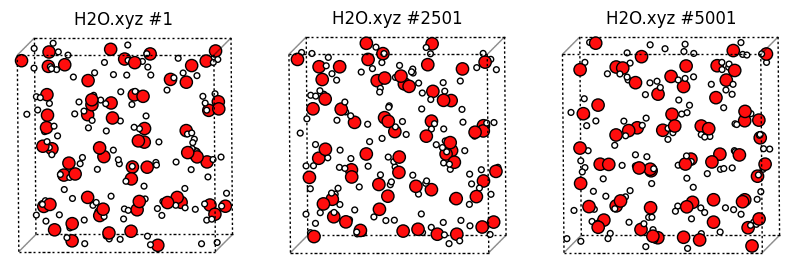

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from common import plot_trajectory
plot_trajectory("trajectories/H2O.xyz");


## Radial distribution functions

In [7]:
%%sh
cat > radf1.config <<EOF
DumpFile trajectories/H2O.xyz
DumpFileFormat mattixyz
MaxTimestep 1000

Overwrite
CoutFrequency 200

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O

RDF H H rdf_h_h.txt Resolution 0.05 MaxDist 6.0
RDF O H rdf_o_h.txt Resolution 0.05 MaxDist 6.0
RDF O O rdf_o_o.txt Resolution 0.05 MaxDist 6.0

EOF
OMP_NUM_THREADS=1 lionanalysis.exe radf1.config > radf1.out


### Plot radial distribution function

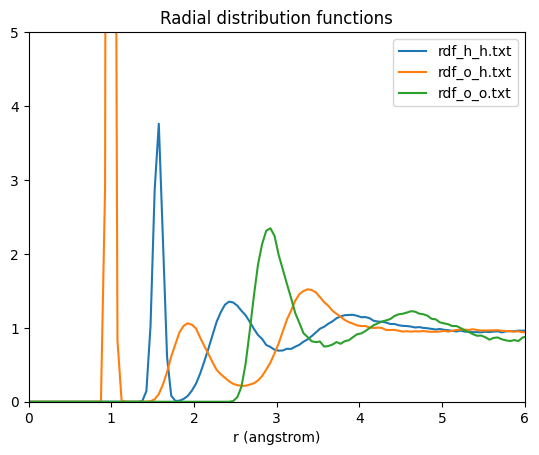

In [8]:
from common import rdf2df
import matplotlib.pyplot as plt

rdf_files = ["rdf_h_h.txt", "rdf_o_h.txt", "rdf_o_o.txt"]
fig, ax = plt.subplots()
for f in rdf_files:
    rdf2df(f).plot(0, 1, xlabel="r (angstrom)", ax=ax)
ax.legend(rdf_files)
ax.set_xlim([0, 6])
ax.set_ylim([0, 5])
ax.set_title("Radial distribution functions");

Here we can see that

* a typical O-H covalent bond is about 1 angstrom (rdf_o_h.txt)
* a typical intermolecular O...H hydrogen bond is about 2 angstrom (rdf_o_h.txt)
* a typical intermolecular O O distance is about 2.9 angstrom (rdf_o_o.txt)
* the first minimum in the O-O rdf is about 3.5 angstrom

## Angular distribution function

With this information, we can define an angular distribution function using the ``AngleRDF`` command:

In [9]:
%%sh
cat > radf2.config <<EOF
DumpFile trajectories/H2O.xyz
DumpFileFormat mattixyz
MaxTimestep 1000

Overwrite
CoutFrequency 200

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O

DefineGroup O_H BOND O H MaxDist 1.2

# Group 1: Accepting O
# Group 2: Donating O
# Group 3: Donating H
# MaxDist12: maximum intermolecular O-O distance
# MaxDist23: arbitrary value greater than O-H covalent bond length
# MaxDist13Frac12 1.0: Ensure that the intermolecular H...O bond is shorter than the intermolecular O...O distance.
AngleRDF \
    Group1 O Group2 O_H Group3 H \
    MaxDist12 3.5 MaxDist23 2.0 MaxDist13Frac12 1.0 MaxDist13 3.5 \
    GroupMustBeInCoordinationShellOf 3 2 MaxAngle 90  \
    AngleResolution 1 DistanceResolution 0.1 FileName ardf.txt
EOF
OMP_NUM_THREADS=1 lionanalysis.exe radf2.config > radf2.out


The ``AngleRDF`` command produces eight output files, ``ardf.txt_1``, .., ``ardf.txt_8``. 

* ``_1``, ``_2``, ``_3``, ``_7`` contain 2D histograms (heat maps)
* ``_4``, ``_5``, ``_6``, ``_8`` contain 1D histograms

In [76]:
%%sh
for f in ardf.txt_?; do echo $f --- $(head -n 1 $f); done

ardf.txt_1 --- #bond(1-o-2-o_h) angle(o-o_h-h) weight
ardf.txt_2 --- #bond(2-o_h-3-h) angle(o-o_h-h) weight
ardf.txt_3 --- #bond(1-o-2-o_h) bond(2-o_h-3-h) weight


ardf.txt_4 --- #bond(1-o-2-o_h) weight(norm) rawcount #### summed over all angles ####
ardf.txt_5 --- #bond(2-o_h-3-h) weight(norm) rawcount #### summed over all angles ####
ardf.txt_6 --- #angle(1-o-2-o_h-3-h) weight(norm) rawcount weight(norm)/sin(theta)### summed over all allowed bond lengths #### totalsum: 190910
ardf.txt_7 --- #bond(1-o-3-h) angle(1-o-2-o_h-3-h) weight
ardf.txt_8 --- #bond(1-o-3-h) weight(norm) rawcount #### summed over all angles ####


### Plot angular distribution function

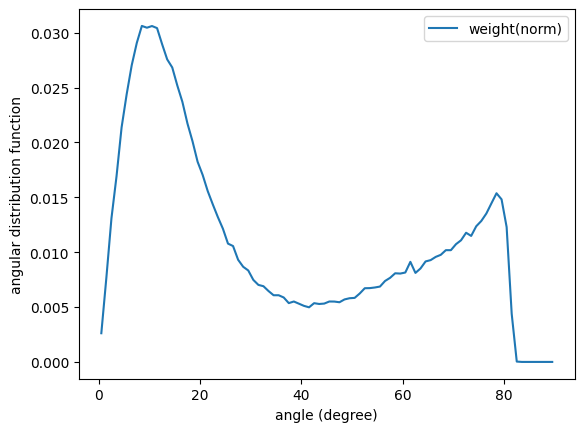

In [3]:
df = pd.read_csv("ardf.txt_6", sep="\s+").iloc[:, :4]
df.head()
fig, ax = plt.subplots()
df.plot(x=0, y=1, xlabel="angle (degree)", ylabel="angular distribution function", ax=ax);

* A common definition is to require the hydrogen bond angle to be smaller than 30 degrees. That covers the majority of the first peak in the above curve. 

* At angles > 80 degrees the curve quickly goes to 0, since at those angles the intermolecular H..O bond is longer than the intermolecular O...O distance, and we had the ``MaxDist13Frac12 1.0`` condition in the input.

We can also resolve the above curve with respect to for example the intermolecular H...O distance:

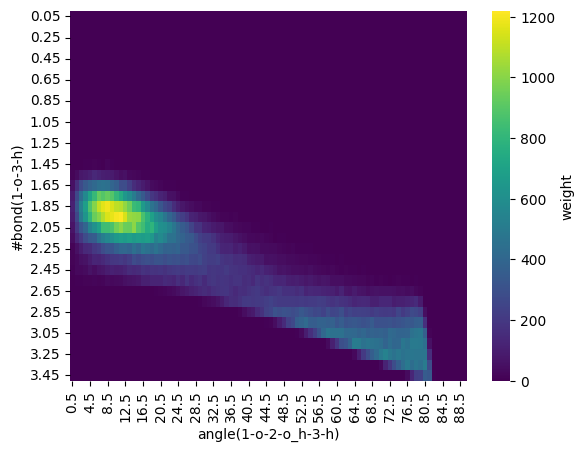

In [6]:
df = pd.read_csv("ardf.txt_7", sep="\s+")
def plot_heatmap(df: pd.DataFrame) -> plt.Axes:
    # Step 2: Reshape the data into a 2D grid (pivot the DataFrame)
    xcol = df.columns[1]
    ycol = df.columns[0]
    zcol = df.columns[2]
    pivot_table = df.pivot(index=ycol, columns=xcol, values=zcol)
    return sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': zcol})

plot_heatmap(df);

Here we see that smaller O...H-O angles are correlated with shorter O...H distances.

## Hydrogen bond statistics and defining groups based on angle criteria

There is a special ``HydrogenBond`` command which is just shorthand for the same ``AngleRDF`` command used above, but with a ``MaxAngle`` of 30. When using it, the actual ``AngleRDF`` command that is used is printed to the output.

Most groups are defined using ``DefineGroup``, but the ``AngleRDF`` command can also be used to define groups. There are two ways: 

* ``CopyGroup`` which includes all the original group members, only the coordination tables depend on the AngleRDF criteria,
* ``NewGroup`` which includes only the group members that contribute a nonzero amount to the AngleRDF.

``CopyGroup`` is thus similar to ``MinCoord 0``, and ``NewGroup`` is similar to ``MinCoord 1``.

In [5]:
%%sh
cat >radf3.config <<EOF
DumpFile trajectories/H2O.xyz
DumpFileFormat mattixyz
CoutFrequency 200
Overwrite
MaxTimestep 1000

DefineGroup O ATOMICNUMBER O
DefineGroup H ATOMiCNUMBER H
DefineGroup O_H BOND O H MaxDist 1.2
DefineGroup H_O BOND H O MaxDist 1.2

HydrogenBond O O_H H \
    CopyGroup1 AcceptorO(AllCN) NewGroup1CoordinationGroup 3 \
    CopyGroup2 DonorO(AllCN) NewGroup2CoordinationGroup 1 \
    CopyGroup3 DonorH(AllCN) NewGroup3CoordinationGroup 1

Histogram hist_acceptor_o_cn.txt DynamicRange GROUPS AcceptorO(AllCN) PROPERTIES coordinationnumber
Histogram hist_donor_o_cn.txt DynamicRange GROUPS DonorO(AllCN) PROPERTIES coordinationnumber
Histogram hist_donor_h_cn.txt DynamicRange GROUPS DonorH(AllCN) PROPERTIES coordinationnumber
PrintProperties acceptor_o_cn.txt GROUPS AcceptorO(AllCN) PROPERTIES timestepiteration coordinationnumber
PrintProperties donor_o_cn.txt GROUPS DonorO(AllCN) PROPERTIES timestepiteration coordinationnumber
PrintProperties donor_h_cn.txt GROUPS DonorH(AllCN) PROPERTIES timestepiteration coordinationnumber

DefineGroup AcceptorO(CN0) SUBGROUPCN AcceptorO(AllCN) Coord 0
DefineGroup AcceptorO(CN1) SUBGROUPCN AcceptorO(AllCN) Coord 1
DefineGroup AcceptorO(CN2) SUBGROUPCN AcceptorO(AllCN) Coord 2
DefineGroup AcceptorO(CN3) SUBGROUPCN AcceptorO(AllCN) Coord 3
DefineGroup DonorO(CN0) SUBGROUPCN DonorO(AllCN) Coord 0
DefineGroup DonorO(CN1) SUBGROUPCN DonorO(AllCN) Coord 1
DefineGroup DonorO(CN2) SUBGROUPCN DonorO(AllCN) Coord 2

# print every 10th frame, and stop after having printed 20 frames
PrintGroup All XYZ acceptor_colors.xyz Every 10 MaxActualPrint 20 SPECIAL \
    AcceptorO(CN1) F \
    AcceptorO(CN2) O \
    AcceptorO(CN3) S

PrintGroup All XYZ donor_colors.xyz Every 10 MaxActualPrint 20 SPECIAL \
    DonorO(CN0) N \
    DonorO(CN1) F \
    DonorO(CN2) O

# To print just the local environment one could either use SingleEnvironment, which takes all atoms within a sphere,
# OR the below rather convoluted way of manipulating coordination tables to print complete water molecules in the environment
# The "@1" will be replaced by 0, 1, 2
# Env1 = add hydrogens of the coordinated oxygens
# Env2 = first get the hydrogens that donate, then their corresponding oxygens, then the oxygens' hydrogens
# Env3 = get the covalently bound hydrogens
# the SUM will combine all coordination environments - it starts with DonorO(CN@1) to guarantee that the first member of the group is a DonorO(CN@1)
# CenterOn 0 CenterAtOrigin will translate the DonorO atom with the environment to the origin 
# There are many thousands of coordination environments, so only print 20 of them - in practice this means that only environments from the first frame are printed.
Loop \
    VARIABLE 0 1 2 \
    COMMAND DefineGroup DonorO(CN@1)Env1 ADDCOORDINATION DonorO(CN@1) O_H \
    COMMAND DefineGroup DonorO(CN@1)Env2 INTERSECTION AcceptorO(AllCN) DonorO(CN@1) \
    COMMAND ModifyGroup DonorO(CN@1)Env2 ADDCOORDINATION DonorO(CN@1)Env2 H_O \
    COMMAND ModifyGroup DonorO(CN@1)Env2 ADDCOORDINATION DonorO(CN@1)Env2 O_H \
    COMMAND DefineGroup DonorO(CN@1)Env3 INTERSECTION O_H DonorO(CN@1) \
    COMMAND DefineGroup DonorO(CN@1)Env SUM DonorO(CN@1) DonorO(CN@1)Env1 DonorO(CN@1)Env2 DonorO(CN@1)Env3 \
    COMMAND PrintGroup DonorO(CN@1)Env XYZ env_donor_cn@1.xyz PrintIndividualCoordinationEnvironments NoEmptyFrames CenterOn 0 CenterAtOrigin MaxActualPrint 20 SPECIAL DonorO(CN0) N DonorO(CN1) F DonorO(CN2) O
EOF
OMP_NUM_THREADS=1 lionanalysis.exe radf3.config > radf3.out

In [4]:
from common import hist2df
from pathlib import Path
hist_files = Path(".").glob("hist*cn.txt")
for f in hist_files:
    print(f"---{f}---")
    print(hist2df(f))

---hist_donor_o_cn.txt---
   #value  #count  #fractional
0       0    1113     0.017391
1       1   15941     0.249078
2       2   46717     0.729953
3       3     229     0.003578
---hist_donor_h_cn.txt---
   #value  #count  #fractional
0       0   18207     0.142242
1       1  109524     0.855656
2       2     269     0.002102
---hist_acceptor_o_cn.txt---
   #value  #count  #fractional
0       0    1546     0.024156
1       1   18737     0.292766
2       2   39876     0.623062
3       3    3791     0.059234
4       4      50     0.000781


Here we see that
* 2% of water molecules donate 0 hydrogen bonds, 25% donate 1, 73% donate 2
* 14% of water hydrogens donate 0 hydrogen bonds, 86% donate 1
* 29% of water oxgens accept 1 hydrogen bond, 62% accept 2, and 6% accept 3

We can note that 0.855 * 0.855 ≈ 0.73, so we might hypothesize that whether a hydrogen donates a hydrogen bond is independent of whether the other hydrogen on the same water molecule donates a hydrogen bond.


As always, let's check out some of these atomic environments to verify that our group definitions are correct. 

Tip: Open these .xyz files in an interactive viewer for easier verification.

### Color based on number of ACCEPTED hydrogen bonds

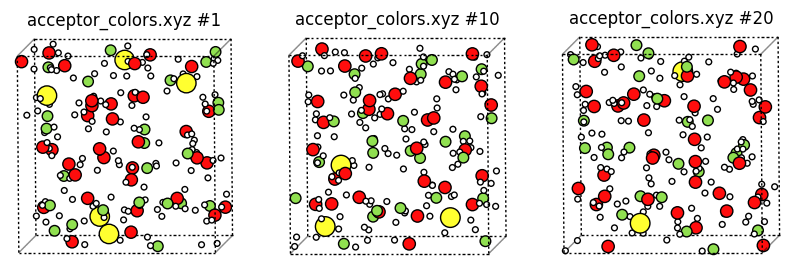

In [48]:
# green: water O accepting 1 hydrogen bond
# red: water O accepting 2 hydrogen bonds
# yellow: water O accepting 3 hydrogen bonds
plot_trajectory("acceptor_colors.xyz");

### Color based on number of DONATED hydrogen bonds

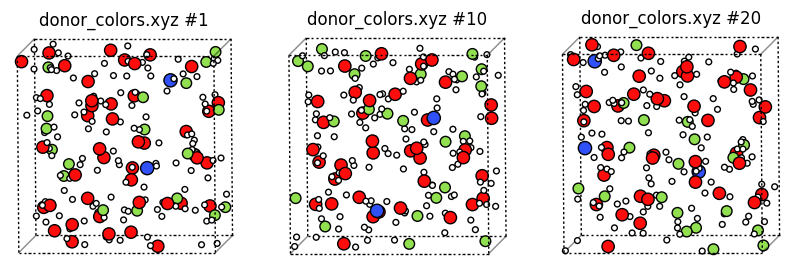

In [49]:
# blue: water O donating 0 hydrogen bonds
# green: water O donating 1 hydrogen bond
# red: water O donating 2 hydrogen bond
plot_trajectory("donor_colors.xyz");

Let's plot just some local coordination environments:

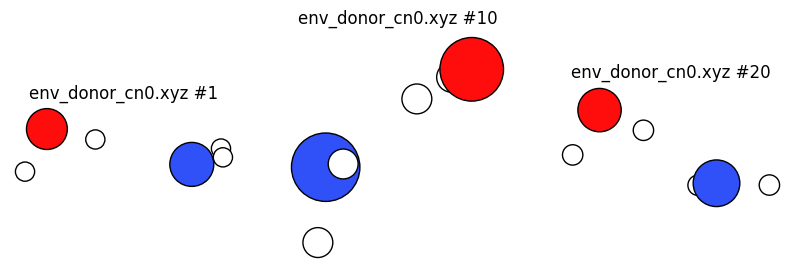

In [50]:
# blue water molecule donate ZERO hydrogen bonds
# only the complete hydrogen bonding environment around ONE blue water molecule is shown
plot_trajectory("env_donor_cn0.xyz", plot_cell=False);

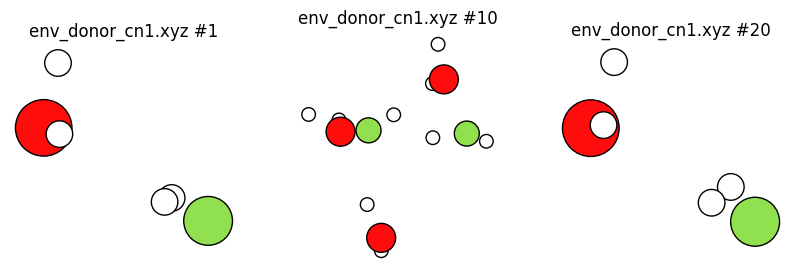

In [51]:
# green water molecules donate ONE hydrogen bond
# only the complete hydrogen bonding environment around ONE green water molecule is shown
plot_trajectory("env_donor_cn1.xyz", plot_cell=False);

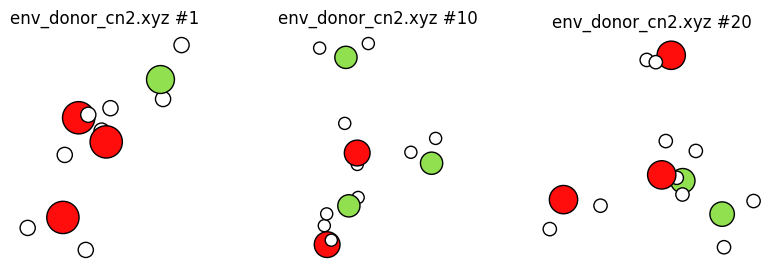

In [52]:
# red water molecules donate TWO hydrogen bonds
# only the complete hydrogen bonding environment around ONE red water molecule is shown
plot_trajectory("env_donor_cn2.xyz", plot_cell=False);

## Plot coordination number vs. frame number

``acceptor_o_cn.txt`` contains the number of accepted hydrogen bonds vs. frame for each oxygen. There are many oxygens, so let's just plot the first two.

In [72]:
%%sh
head acceptor_o_cn.txt

#iter acceptoro(allcn) 
1 1 2 2 0 3 2 3 2 3 1 2 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 1 1 2 1 2 2 2 1 2 3 1 1 3 1 1 2 2 2 2 1 1 1 2 1 1 2 2 1 1 2 1 2 2 1 1 2 
2 1 2 2 0 2 2 3 2 3 1 2 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 1 1 2 1 1 2 2 1 2 3 1 1 3 2 1 2 2 2 2 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 1 3 
3 1 2 2 1 2 2 3 2 3 1 2 1 2 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 1 1 2 2 1 2 2 1 2 3 2 1 3 2 1 2 2 2 2 1 1 1 2 1 1 2 2 1 1 2 0 2 2 1 1 3 
4 1 2 2 1 2 2 3 2 2 1 2 1 2 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 1 1 2 2 1 2 2 2 2 3 2 1 3 2 1 2 2 2 2 1 1 1 2 1 1 2 2 1 1 2 0 2 2 2 1 3 
5 1 2 2 1 2 2 3 2 2 1 2 1 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 2 2 3 1 1 3 1 1 2 2 2 2 1 1 1 2 1 1 2 1 2 1 2 0 2 2 2 1 3 
6 1 2 2 1 2 2 3 2 2 1 2 1 2 2 2 2 2 2 0 1 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 2 2 3 1 1 3 2 1 2 2 2 2 2 2 1 2 1 1 2 0 2 1 2 1 2 2 2 3 3 
7 1 3 2 1 2 2 3 2 2 1 2 1 2 2 2 1 2 2 0 1 2 1 2 2 2 2 2 2 1 1 2 1 1 2 2 2 2 3 1 1 3 2 1 2 2 2 2 2 2 1 2 1 1 2 1 2 1 2 1 2 2 2 3 3 
8 1 2 2 1 2 2 3 2 2 1 2 1 2 2 3 1 2 2 0 1 2 1 2 2 2 2 2 2 1

In [93]:
df = pd.read_csv("acceptor_o_cn.txt", delimiter="\s+", header=None, skiprows=1)
df.columns = ['iteration'] + [f'O{i+1}' for i in range(df.shape[1]-1)]
df.head()

,iteration,O1,O2,O3,O4,O5,O6,O7,O8,O9,...,O55,O56,O57,O58,O59,O60,O61,O62,O63,O64
0,1,1,2,2,0,3,2,3,2,3,...,2,1,1,2,1,2,2,1,1,2
1,2,1,2,2,0,2,2,3,2,3,...,1,1,1,2,1,2,1,1,1,3
2,3,1,2,2,1,2,2,3,2,3,...,2,1,1,2,0,2,2,1,1,3
3,4,1,2,2,1,2,2,3,2,2,...,2,1,1,2,0,2,2,2,1,3
4,5,1,2,2,1,2,2,3,2,2,...,1,2,1,2,0,2,2,2,1,3


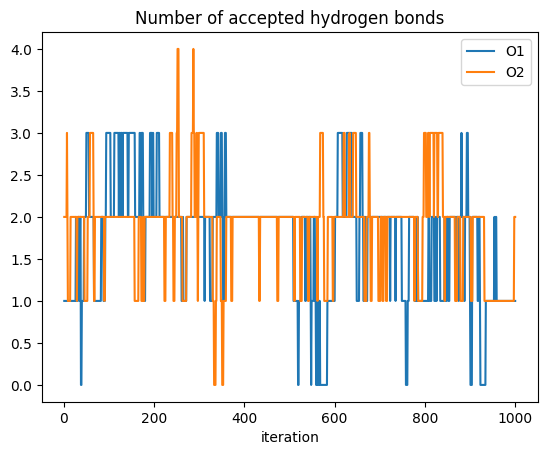

In [103]:
df.plot(x="iteration", y=["O1", "O2"], title="Number of accepted hydrogen bonds");

We see that the hydrogen bonding environment fluctuates during the simulation. In a future notebook, these kinds of fluctuations are analyzed in more detail to calculate the hydrogen bond lifetime.

NOTE: The above plot is valid only because the order of the oxygen atoms as printed in acceptor_o_cn.txt will follow the order of oxygens in the trajectory, and that is the case because

* The trajectory is written with oxygens always in the same order
* The AcceptorO(AllCN) group is defined using CopyGroup based on the group O which is defined using ATOMICNUMBER, and ATOMICNUMBER both preserves atom order and contains all oxygen atoms.

In general you SHOULD NOT assume that the atom order from PrintProperties matches the order in the trajectory.